In [113]:
import obspy as os
import obspy.signal
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import clients

import numpy as np
import matplotlib.pyplot as plt
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth

In [114]:
from obspy import UTCDateTime

#This is a dictionary 

big_events = { "Japan_2011": { "start_time": UTCDateTime("2011-03-11T05:46:23"), 
                              "latitude": 38.297, "longitude": 142.372, "depth_km": 29
                             },
               "Alaska_2021": { "start_time": UTCDateTime("2021-07-29T06:15:49"),
                                "latitude": 55.325,"longitude": -157.972, "depth_km": 32
                              },
               "Russia_2025": {"start_time": UTCDateTime("2025-07-25T00:15:30"),
                               "latitude": 54.000, "longitude": 160.0000, "depth_km": 25
                              }
            }

# This shows a network and station pairing 
                # so AF is the network while ["AAUS", "ANKE", "DESE", "EKNA", "IFE", "KAD", "NSU"] is the station. 
                # This applies to the rest for clarity
network_stations = {
                        "AF": ["AAUS", "ANKE", "DESE", "EKNA", "IFE", "KAD", "NSU"],
                        "AU": ["MCQ"],
                        "G": ["ATD", "TAM"],
                        "IM": ["TOA1", "TOA2", "TOA3", "TOB1", "TOB2", "TOB3", "TOB4", "TOB5", "TORD"],
                        "IP": ["MTOR"],
                        "IU": ["FURI", "MACI"],
                        "NJ": ["AWK", "IFE", "KAD", "NSU", "TORO"],
                        "NZ": ["CTZ"]
}

In [115]:
client = Client('IRIS')
model = TauPyModel(model = "ak135")         # In the dropdown menu we can have models using either models "iasp91", "ak135", "ak135f", "prem"


selected_event = "Japan_2011"  #There should be a dropdown for selected events: Japan_2011, Alaska_2021 and Russia_2025
selected_network = "IU"        #I don't know how this will be connected to networ_stations, i don't know how 
selected_station = "PAYG"
selected_channel = "BHZ"       # We can have a drop down for three channels(BH1, BH2, BHZ), for now maybe just focu
selected_location = "*"        # Thwill serve as a wildcat (*), you can use various wildcat tho in the drop down, 
                               # eg BH?, LH?

event = big_events[selected_event]
start_time = event["start_time"]
trace_length = 4000             # If possible we can have drop downs for trace length 
end_time = start_time + trace_length
event_lat = event["latitude"]
event_lon = event["longitude"]
event_depth_km = event["depth_km"]

In [116]:
# Class: Dropdown should be Japan_2011, Alaska_2021, Russia_2025
# Subclass: For the Earthquakes, it should be Network insteead of Subclasses
# Site:     For site, it should be Stations

In [117]:
try:
    st = client.get_waveforms(selected_network, selected_station, selected_location,
                              selected_channel, start_time, end_time, attach_response=True
                             )
    st_rem = st.copy()
    st_rem.remove_response(output="VEL")
    st_rem.detrend('linear')
    st_rem.detrend('demean')
    tr = st_rem[0]
except Exception as e:
    print(f"There was a download error, please check inputs Maybe incorrect channel, station and network name Ensure your input is correct and well written: {e}")

In [118]:
inv = client.get_stations( network=selected_network, station=selected_station,
                           level="station", starttime=start_time, endtime=end_time
                         )
sta = inv[0][0]
station_lat = sta.latitude
station_lon = sta.longitude
distance_deg = locations2degrees(event_lat, event_lon, station_lat, station_lon)

In [119]:
# I neeed a drop down for the the filter ranges

filter_ranges = [(0.01, 0.10), 
                 (0.05, 0.2), 
                 (0.01, 0.5), 
                 (0.03, 0.1), 
                 (0.03, 0.15)]      

nrows = len(filter_ranges) + 1 
    
phase_types = ["P", "S", "SKS", "SKKS"]   
                                                    #This part shows the TauP phases we wanna overlay on the plots
                                                    # What this does that is shows the body waves(P&S) arrival amongst others
arrival_colors = {'P': 'r', 
                  'S': 'g', 
                  'SKS': 'b', 
                  'SKKS': 'm'}

colors = [
            'k', 'r', 'b', 'g',                   
            'orange','purple',         
            'cyan','magenta',     
            'brown','olive',
            'teal','pink','gold'
            'darkred', 'navy',  
        ]

The range of frequencies is from:, freqmin, freqmax,  Hz


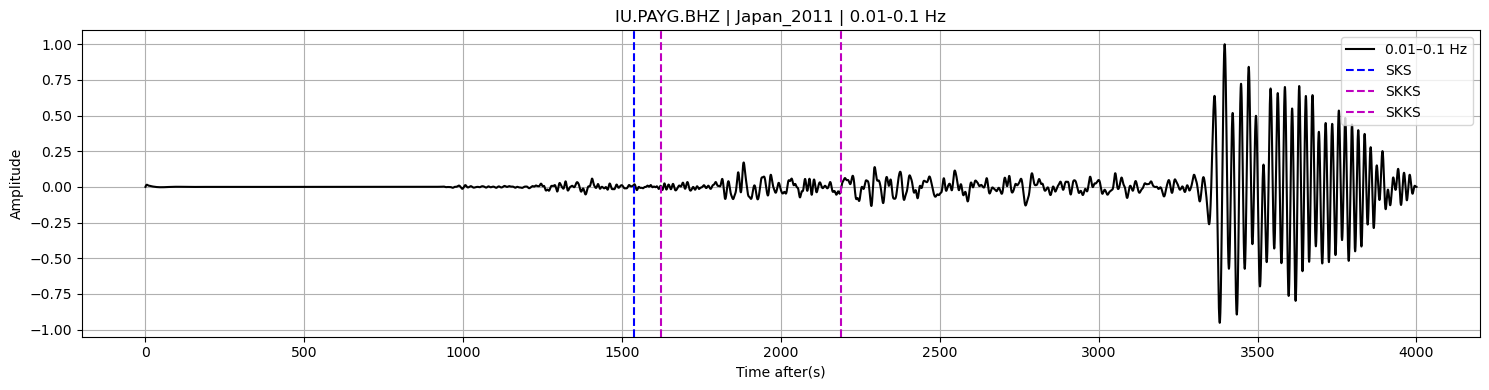

The range of frequencies is from:, freqmin, freqmax,  Hz


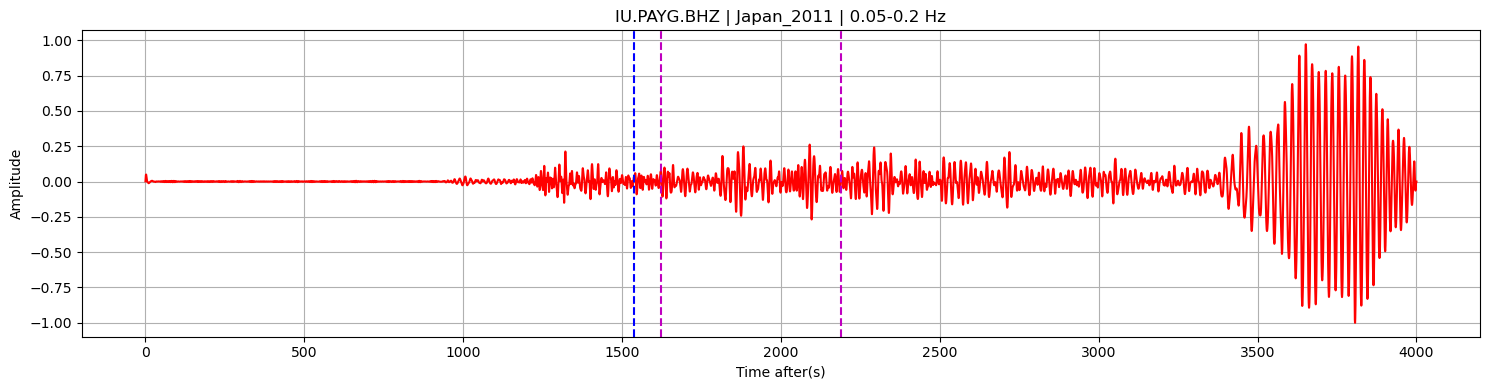

The range of frequencies is from:, freqmin, freqmax,  Hz


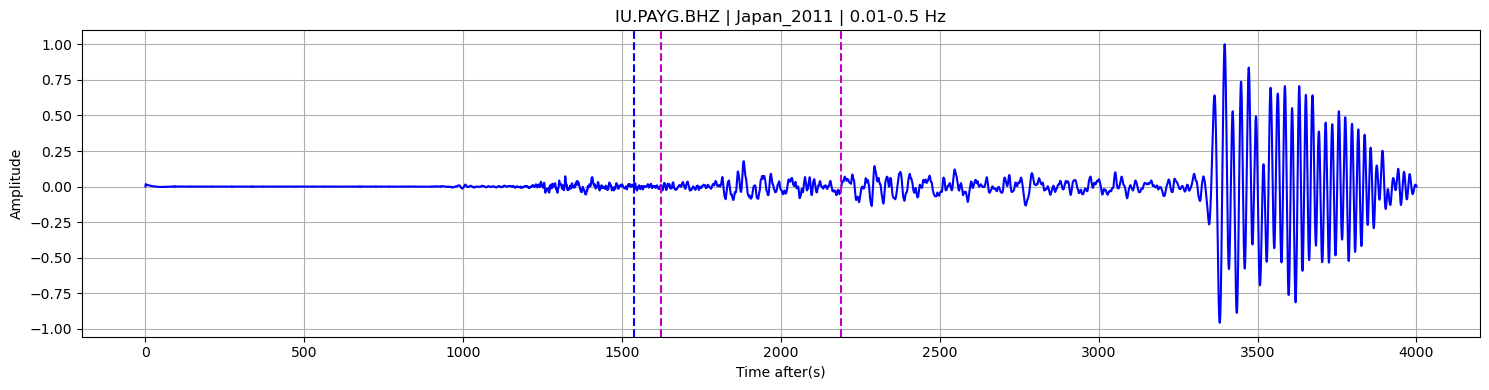

The range of frequencies is from:, freqmin, freqmax,  Hz


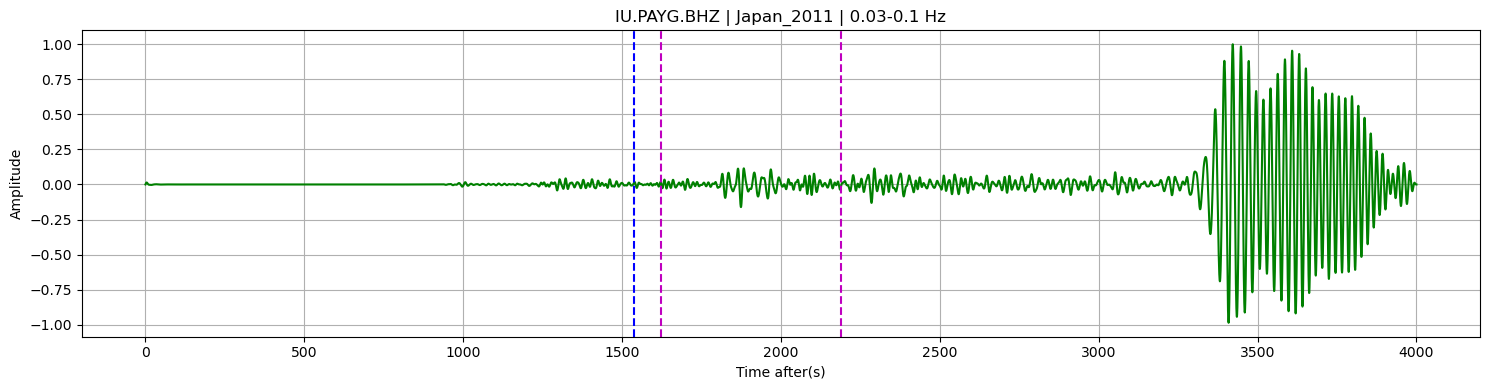

The range of frequencies is from:, freqmin, freqmax,  Hz


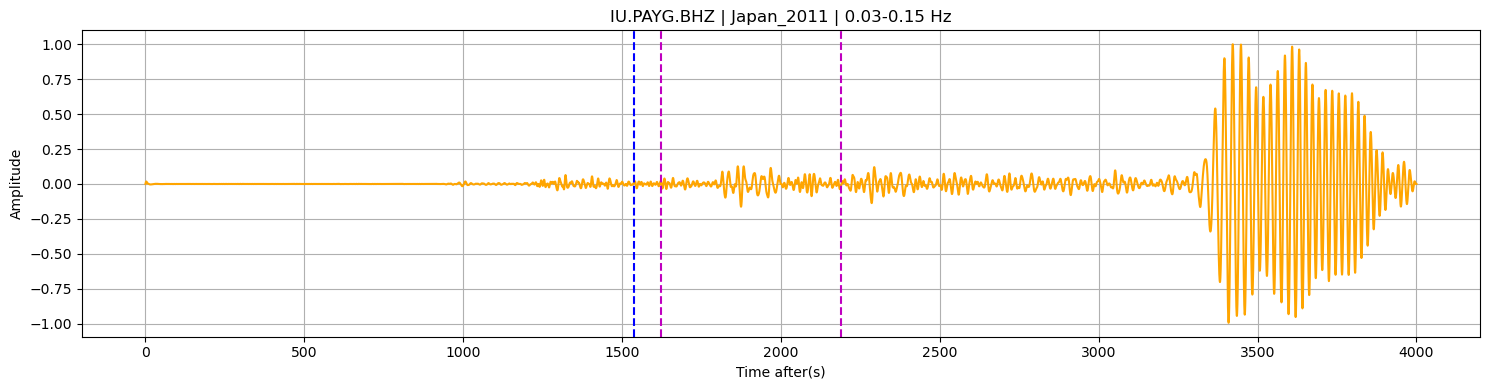

In [120]:
try:
    # Get waveform
    st = client.get_waveforms(
        selected_network, selected_station, selected_location,
        selected_channel, start_time, end_time, attach_response=True
    )

    # This are jus Basic Preprocessing Methods
    st_rem = st.copy()
    st_rem.remove_response(output="VEL")
    st_rem.detrend('linear')
    st_rem.detrend('demean')
    tr = st_rem[0]  # Trace extracted here

    # Get station metadata
    inv = client.get_stations(
        network=selected_network, station=selected_station,
        level="station", starttime=start_time, endtime=end_time
    )
    sta = inv[0][0]
    station_lat = sta.latitude
    station_lon = sta.longitude

    # computing epicentral distances in degree
    distance_deg = locations2degrees(event_lat, event_lon, station_lat, station_lon)

    for i, (fmin, fmax) in enumerate(filter_ranges):
        tr_filt = tr.copy()
        tr_filt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
        print("The range of frequencies is from:, freqmin, freqmax,  Hz")
        tr_filt.data = tr_filt.data / max(abs(tr_filt.data))
        t = tr_filt.times("relative")

        arrivals = model.get_travel_times(
            source_depth_in_km=event_depth_km,
            distance_in_degree=distance_deg,
            phase_list=phase_types
        )
        color = colors[i % len(colors)]  

        plt.figure(figsize=(15, 4))
        plt.plot(t, tr_filt.data, label=f'{fmin}–{fmax} Hz', color=color)
        plt.xlabel("Time after(s)")
        plt.ylabel("Amplitude")
        plt.title(f"{selected_network}.{selected_station}.{selected_channel} | {selected_event} | {fmin}-{fmax} Hz")

        for arr in arrivals:
            if arr.name in arrival_colors:
                plt.axvline(arr.time, color=arrival_colors[arr.name], linestyle='--', label=arr.name)

        plt.grid(True)
        if i == 0:
            plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f" Error occurred: {e}\nCheck network/station/channel values or time window.")

In [121]:
tr_filt.stats
print(tr_filt.stats)
sampling_freq = tr_filt.stats.sampling_rate
print(sampling_freq)

               network: IU
               station: PAYG
              location: 00
               channel: BHZ
             starttime: 2011-03-11T05:46:23.019538Z
               endtime: 2011-03-11T06:53:02.969538Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 80000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 341, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 472064})
            processing: ['ObsPy 1.4.2: trim(endtime=UTCDateTime(2011, 3, 11, 6, 53, 3, 19538)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 3, 11, 5, 46, 23, 19538))', "ObsPy 1.4.2: remove_response(fig=None::inventory=None::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)", "ObsPy 1.4.2: detrend(options={}::ty

In [122]:
tr_filt.data.station

AttributeError: 'numpy.ndarray' object has no attribute 'station'

In [46]:
# Stop Here for now ...............

In [ ]:
 # The code her 

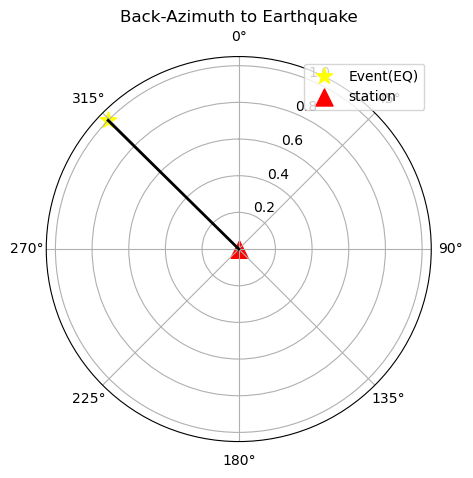

In [74]:
# The Rose Diagram
_, azimuth, _ = gps2dist_azimuth(station_lat, station_lon, event_lat, event_lon)
azimuth_rad = np.deg2rad(azimuth)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, polar=True)

ax.plot([0, azimuth_rad], [0, 1], color='black', linewidth=2, label='Back-Azimuth')
ax.scatter(azimuth_rad, 1, color='yellow', marker='*', s=200, label='Earthquake', edgecolor='black', zorder=5)
ax.scatter(0, 0, color='red', marker='^', s=200, label='Station', edgecolor='black', zorder=5)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 1)
ax.set_rlabel_position(135)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_title("Back-Azimuth to Earthquake", fontsize=14, pad=20)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), fontsize=11, frameon=True)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(0.8)
plt.tight_layout()
plt.show()

In [ ]:
st